# NARMA10 task

This task consists in predicting the output of a 10-th order non-linear autoregressive moving average (NARMA) system.
- [Reference paper](https://doi.org/10.1016/j.neunet.2011.02.002)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools

import torch
from torch import cuda, zeros, Tensor, optim
from torch.nn import Module, ModuleList, Sequential, Linear, Tanh, MSELoss, RNN

from sklearn.metrics import mean_squared_error
# from grid import GS


The input of the system is a sequence of elements 𝑥(𝑡) randomly chosen according to a uniform distribution over [0, 0.5]. 

Given the input value 𝑥(𝑡), the task is to predict the corresponding value of 𝑦(𝑡).

- Import the dataset from the .csv file *NARMA10.csv*, where the first row represents the input and the second row represents the
target output. Different columns represent different time-steps.
- Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
    - For the sake of problem understanding, you can try to first visualize the timeseries data

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
dset = pd.read_csv('./data/NARMA10.csv', header=None).to_numpy()
x = dset[0]
y = dset[1]
x_test = x[:5000]
train = x[5000:] 

x_train = train[:4000]
x_val = train[4000:]

y_test = y[:5000]
train_y = y[5000:] 

y_train = train_y[:4000]
y_val = train_y[4000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((4000,), (4000,), (1000,), (1000,), (5000,), (5000,))

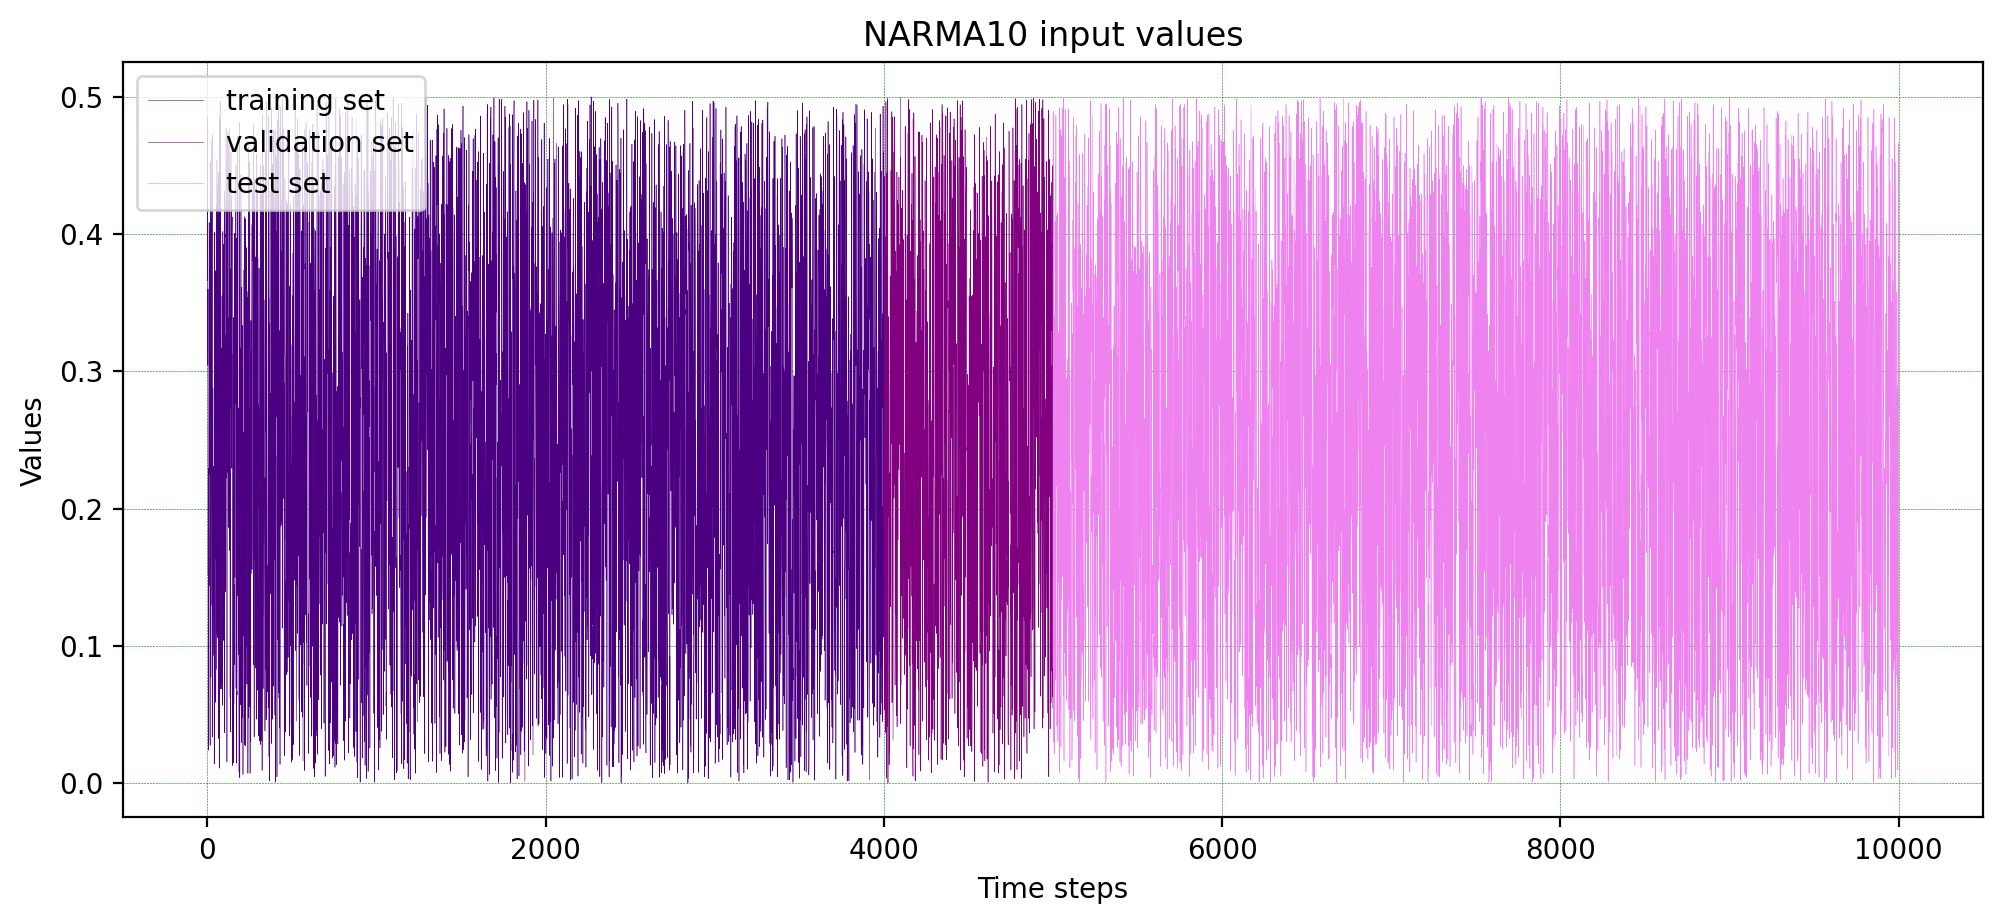

In [4]:
# plot_ts(x_train,x_val,x_test, "NARMA10 input values")

limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.2, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.2, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.2, label="test set") 

plt.title('NARMA10 input values')
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
#plt.savefig(str('plots/timeseries.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()

**Remember:** when training an RNN you want to make sure to keep the last hidden state of your RNN after the training session, and use it as initial hidden state of the validation session.
Same applies when transitioning to the test session

In [5]:
# This class `GS` implements a grid search algorithm to find the best model configuration for either a
# TDNN or RNN neural network based on specified parameters and datasets.
class GS:
    
    def __init__(self, parameters:dict, Xset, Yset, neuralnet:str):
        self.Xset=Xset
        self.Yset=Yset
        param_grid = self.grid(parameters) #self, 
        min_loss, best_model = self.search(param_grid, neuralnet) #self, 
        self.min_loss = min_loss
        self.best_model = best_model # the best model discovered

    # @staticmethod
    def grid(self, params):
        param_names=list(params.keys())
        param_values=list(params.values())
        param_combinations=list(itertools.product(*param_values))
        
        param_grid=[]
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid 
        
    @staticmethod
    def get_optimizer(model, optimizer_name, lr):
        if optimizer_name == 'adam':
            return optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'sgd':
            return optim.SGD(model.parameters(), lr=lr)
        else:
            raise ValueError("Unknown optimizer: {}".format(optimizer_name))
        
    # @staticmethod
    def search(self, param_grid:tuple, neuralnet:str):#, Xset, Yset):
        predictions={}  
        for pg in param_grid:
            print(f'Parameters: {pg}')
            if neuralnet=='TDNN':
                model=TDNN_model(
                    window=pg['window'],
                    layers=pg['layers'],
                    input_dim=self.Xset.shape[0],
                    epochs=pg['epochs'],
                    hidden_dim=pg['hiddens']       
                )
            elif neuralnet=='RNN':
                model=RNN_model(
                    input_dim=self.Xset.size(0), #self.Xset.shape[1]
                    layers=pg['layers'],
                    epochs=pg['epochs'],
                    hidden_dim=pg['hiddens']
                ) 
            optimizer = self.get_optimizer(model, pg['opt'], pg['lr'])      
            loss, y_pred=model.train(self.Xset, self.Yset, optimizer)#
            predictions[min(loss)]=[pg, y_pred] 
        
        
        # predictions=dict(sorted(predictions.items()))
        # print(next(iter(predictions.items())))
        # min_loss=list(predictions.keys())[0]
        min_loss = min(predictions.keys())
        # best_model=list(predictions.values())[0]
        best_model = predictions[min_loss]
        
        return min_loss, best_model

In [6]:
# With this function, you obtain a 1x[window_size]x4000 Torch Tensor 
# to pass to the TDNN as preprocessed input data

def input_prep(window:int, input_data:np.array):
        input_len=len(input_data)
        prep_input=torch.zeros([1, input_len, window])
        for i in range(0, input_len):
            #if((i+window) <= input_len): 
                tmp=input_data[i:i+window]
                #prep_input[0,i,:]=tmp 
                for j in tmp:
                    prep_input[0,i,:]=j
        # print('TENSOR:', prep_input.shape)
        return prep_input


In [7]:
def plot_results(tr_y, tr_y_pred, ts_y, ts_y_pred, nn):
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.suptitle(nn)

    plt.subplot(2, 1, 1)
    plt.plot(tr_y, label="True",linewidth=0.2)
    plt.plot(tr_y_pred, label="Predicted", linewidth=0.2)
    plt.title('Training Data')
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(ts_y, label="True", linewidth=0.2)
    plt.plot(ts_y_pred, label="Predicted", linewidth=0.2)
    plt.title('Test Data')
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.legend()

    plt.tight_layout()
    plt.savefig(str('plots/'+nn+'_results.jpeg'), edgecolor='black', dpi=400, transparent=True)
    plt.show()
    
#target = target_data.reshape(1, -1, 1)
#y_pred = y_pred.detach().numpy()

def loss_plot(tr_losses, ts_losses):
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.suptitle(nn)
    
    # plt.subplot(2, 1, 1)
    plt.title('Loss history')
    plt.plot([loss for loss in tr_losses], label="Training")
    plt.plot([loss for loss in ts_losses], label="Test")
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.grid()
    
    plt.tight_layout()
    plt.savefig(str('plots/'+nn+'_loss.jpeg'), edgecolor='black', dpi=400, transparent=True)
    plt.show()

In [ ]:
############################
#   TDNN: every epoch you pass all the matrix input (window)
#   RNN: every epoch you pass a timestep and let it run
############################

## Time-delay neural network

In [ ]:

''' 
This is a PyTorch neural network model class that implements a simple TDNN architecture with a
specified number of hidden layers and dimensions. 
'''

class TDNN_model(torch.nn.Module):
    def __init__(self, window:int, layers:int, input_dim:int, epochs:int, hidden_dim:int): 
        super(TDNN_model, self).__init__()
        
        hidden_layers = [] #torch.nn.ModuleList()
        # hidden = torch.nn.ModuleList([torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim)])
        # self.all_layers.append([hidden for i in range(1,layers)])
        
        for _ in range(layers):
            hidden_layers.append(torch.nn.Dropout(0.5)) 
            hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(torch.nn.ReLU())
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(window, hidden_dim), #window*input_dim
            torch.nn.ReLU(),
            *hidden_layers,
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Tanh()
            ) 
        
        
        self.window=window   
        self.epochs=epochs   
        
                
    def train(self, input_data:Tensor, target_data:Tensor, optimizer):
        #create sequences of data
        timesteps=input_prep(self.window, input_data)
        #pass them to the model        
        #then to the optimizer
        target = torch.tensor(target_data, dtype=torch.float32).reshape(1, -1, 1)
        # target=input_prep(self.window, target_data) #self.window
        losses=[]
        for e in range(1,self.epochs):
            optimizer.zero_grad()
            y_pred = self.model(timesteps)
            # print(f'Target shape: {target.shape}, Predicted shape: {y_pred.shape}')
            mse = MSELoss()
            # y_pred = y_pred.detach().numpy().squeeze()
            loss = mse(y_pred, target) 
            #  (torch.tensor(target_data)).unsqueeze(0).unsqueeze(-1)
            # loss = float(loss)
            # print(f'Loss: {loss}')
            if loss is not None:
                # optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
                losses.append(loss.item())
        print(f'Loss: {min(losses)} \n-----------------------------------------------------')
                #catch loss and history and get them back to the grid search for storage and evaluation
        return(losses, y_pred)    

In [ ]:
# # adam=torch.optim.Adam()
# # sgd=torch.optim.SGD()
params={
    'epochs':[100, 500], #1000
    'layers':[1, 2, 5], #, 3, 5 
    'hiddens':[64, 128],  #, 256
    'window':[5,10], #15, 20, 50
    'lr':[0.001, 0.01], # 0.1, 0.0001, 
    'opt':['adam', 'sgd']
}

In [ ]:
nn='TDNN'
grid_search=GS(params, x_train, y_train, nn) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model
tr_ypred = best_model[1]


grid_search_val=GS(params, x_val, y_val, nn) 
best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
best_params = best_model_val[0]


print('\nBest training loss: ', best_loss, '\n Best training model: ', best_model[0])

print('Cross validation: \n best loss on validation: ', best_loss_val, '\n best model parametrization based on validation: ',best_params)


Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 5, 'lr': 0.001, 'opt': 'adam'}
Loss: 0.008364588022232056 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 5, 'lr': 0.001, 'opt': 'sgd'}
Loss: 0.062036167830228806 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 5, 'lr': 0.01, 'opt': 'adam'}
Loss: 0.007449869532138109 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 5, 'lr': 0.01, 'opt': 'sgd'}
Loss: 0.010045173577964306 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 10, 'lr': 0.001, 'opt': 'adam'}
Loss: 0.008620472624897957 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 1, 'hiddens': 64, 'window': 10, 'lr': 0.001, 'opt': 'sgd'}
Loss: 0.047

##### Final retraining

In [21]:
x_whole = np.concatenate([x_train, x_val])
y_whole = np.concatenate([y_train, y_val])

In [ ]:
print('Whole training set:')
tdnn = TDNN_model(best_params['window'], best_params['layers'], x_whole.shape[0], best_params['epochs'], best_params['hiddens'] )
optimizer = GS.get_optimizer(tdnn, best_params['opt'], best_params['lr'])  
whole_loss, whole_ypred=tdnn.train(x_whole, y_whole,optimizer) 


print('Test:')
tdnn = TDNN_model(best_params['window'], best_params['layers'], x_test.shape[0], best_params['epochs'], best_params['hiddens'])
optimizer = GS.get_optimizer(tdnn, best_params['opt'], best_params['lr'])  
test_loss, test_ypred=tdnn.train(x_test, y_test,optimizer) 



Whole training set:
Loss: 0.007274009753018618 
-----------------------------------------------------
Test:
Loss: 0.007614443078637123 
-----------------------------------------------------


In [ ]:
y_whole.shape, whole_ypred.shape, y_test.shape, test_ypred.shape

((5000,), torch.Size([1, 5000, 1]), (5000,), torch.Size([1, 5000, 1]))

In [ ]:
whole_ypred_NP = whole_ypred.detach().numpy().astype('float64')
test_ypred_NP = test_ypred.detach().numpy().astype('float64')

In [ ]:
whole_ypred_f=whole_ypred_NP.flatten()
test_ypred_f=test_ypred_NP.flatten()
whole_ypred_f.shape, test_ypred_f.shape

((5000,), (5000,))

In [ ]:
y_whole.shape, whole_ypred_f.shape, y_test.shape, test_ypred_f.shape

((5000,), (5000,), (5000,), (5000,))

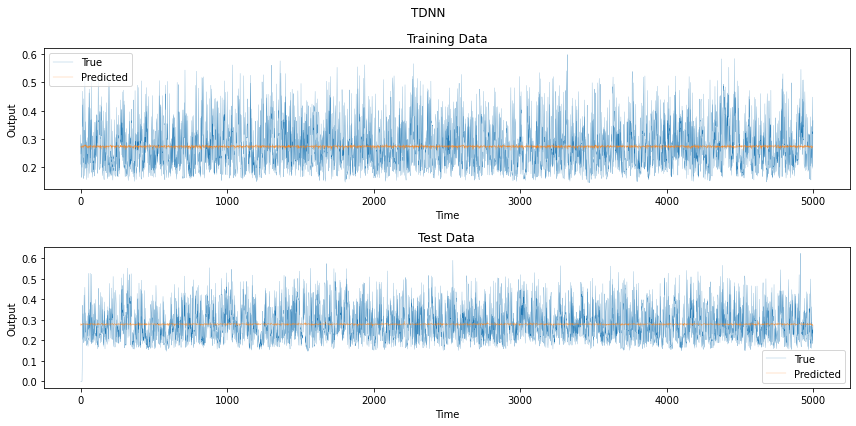

In [ ]:
plot_results(y_whole, whole_ypred_f, y_test, test_ypred_f, nn) 

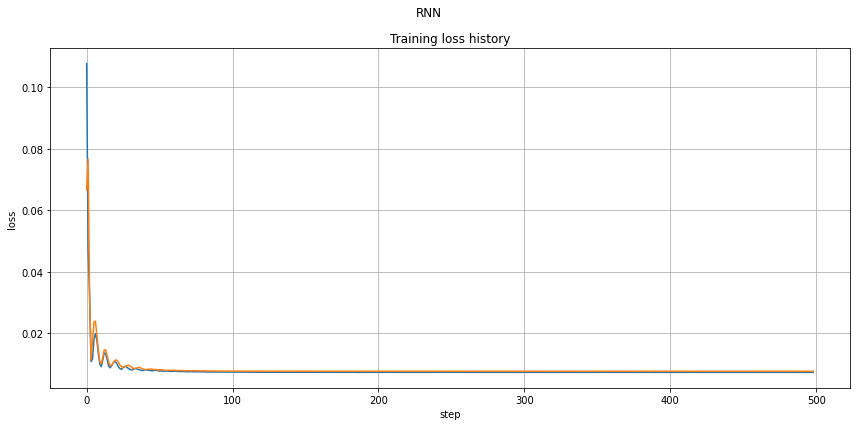

In [ ]:
loss_plot(whole_loss, test_loss)

## Recurrent neural network

In [10]:
''' 
This is a PyTorch neural network model class that implements a simple RNN architecture with a
specified number of hidden layers and dimensions. 
'''

class RNN_model(torch.nn.Module):
    def __init__(self, input_dim:int, layers:int, epochs:int, hidden_dim:int):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers

        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layers, nonlinearity='tanh', bias=False, batch_first=True)
        self.readout = torch.nn.Linear(hidden_dim, 1)
        
        self.epochs=epochs
        
        
    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim)
        out, hn = self.rnn(x, h0) 
        out = self.readout(out) 
        h0=hn
        return out
    
    
    
    def train(self, input_data:Tensor, target_data:Tensor, optimizer):
        losses=[]
        for e in range(1,self.epochs):
            optimizer.zero_grad()
            y_pred= self.forward(input_data)
            mse = MSELoss()
            loss = mse(y_pred, target_data)
            if loss is not None:
                # optimizer.zero_grad()
                loss.backward()
                optimizer.step()  
                losses.append(loss.item())  
        print(f'Loss: {min(losses)} \n-----------------------------------------------------')       
                ###catch loss and history and get them back to the grid search for storage and evaluation
        return(losses, y_pred)    
        


In [11]:
# adam=torch.optim.Adam()
# sgd=torch.optim.SGD()
params={
    'epochs':[100], #1000
    'layers':[2,5],#10, 3 
    'hiddens':[64, 128], #64, 256
    'lr':[0.001, 0.01], #0.1
    'opt':['adam', 'sgd']
}


nn='RNN'
x_tr =  torch.from_numpy(np.reshape(x_train, (1, 4000, 1))).float() 
y_tr =  torch.from_numpy(np.reshape(y_train, (1, 4000, 1))).float() 

x_v =  torch.from_numpy(np.reshape(x_val, (1, 1000, 1))).float() 
y_v =  torch.from_numpy(np.reshape(y_val, (1, 1000, 1))).float() 


grid_search=GS(params, x_tr, y_tr, nn) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model
# print('best loss: ', best_loss, '\n best model: ', best_model)
print('best training loss: ', best_loss)

grid_search_val=GS(params, x_v, y_v, nn) 
best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
best_params = best_model_val[0]
# print('Cross validation: \n best loss on validation: ', best_loss_val.item(), '\n best model parametrization based on validation: ',best_params)

Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 64, 'lr': 0.001, 'opt': 'adam'}
Loss: 0.002655294258147478 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 64, 'lr': 0.001, 'opt': 'sgd'}
Loss: 0.0631059929728508 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 64, 'lr': 0.01, 'opt': 'adam'}
Loss: 0.00516614830121398 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 64, 'lr': 0.01, 'opt': 'sgd'}
Loss: 0.007127780932933092 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 128, 'lr': 0.001, 'opt': 'adam'}
Loss: 0.003877869341522455 
-----------------------------------------------------
Parameters: {'epochs': 100, 'layers': 2, 'hiddens': 128, 'lr': 0.001, 'opt': 'sgd'}
Loss: 0.07632588595151901 
-----------------------------------------------------
Parameters:

AttributeError: 'float' object has no attribute 'item'

In [12]:
print('Cross validation: \n best loss on validation: ', best_loss_val, '\n best model parametrization based on validation: ',best_params)

Cross validation: 
 best loss on validation:  0.0013542689848691225 
 best model parametrization based on validation:  {'epochs': 100, 'layers': 5, 'hiddens': 64, 'lr': 0.001, 'opt': 'adam'}


##### Final retraining

In [24]:
x_t =  torch.from_numpy(np.reshape(x_test, (1, 5000, 1))).float() 
y_t =  torch.from_numpy(np.reshape(y_test, (1, 5000, 1))).float() 

# whole_x =  torch.from_numpy(np.reshape(np.concatenate([x_train, x_val]), (1, 5000, 1))).float() 
# whole_y =  torch.from_numpy(np.reshape(np.concatenate([y_train, y_val]), (1, 5000, 1))).float() 
whole_x =  torch.from_numpy(np.reshape(x_whole, (1, 5000, 1))).float() 
whole_y =  torch.from_numpy(np.reshape(y_whole, (1, 5000, 1))).float() 


print('Loss on whole training set:')

rnn = RNN_model(whole_x.size(0), best_params['layers'], best_params['epochs'], best_params['hiddens'])
optimizer = GS.get_optimizer(rnn, best_params['opt'], best_params['lr'])  
whole_loss_rnn, whole_ypred=rnn.train(whole_x, whole_y,optimizer) 

print('Test loss')
rnn = RNN_model(x_t.size(0), best_params['layers'], best_params['epochs'], best_params['hiddens'])
optimizer = GS.get_optimizer(rnn, best_params['opt'], best_params['lr'])  
test_loss_rnn, test_ypred=rnn.train(x_t, y_t,optimizer) 

# print('Best loss: \n Whole training set: ', whole_loss.item(), '\n Test: ', test_loss.item())

Loss on whole training set:
Loss: 0.002877227496355772 
-----------------------------------------------------
Test loss
Loss: 0.0032030693255364895 
-----------------------------------------------------


In [26]:
whole_ypred_NP = whole_ypred.detach().numpy().flatten()
test_ypred_NP = test_ypred.detach().numpy().flatten()

whole_y_NP = whole_y.detach().numpy().flatten()
y_t_NP=y_t.detach().numpy().flatten()

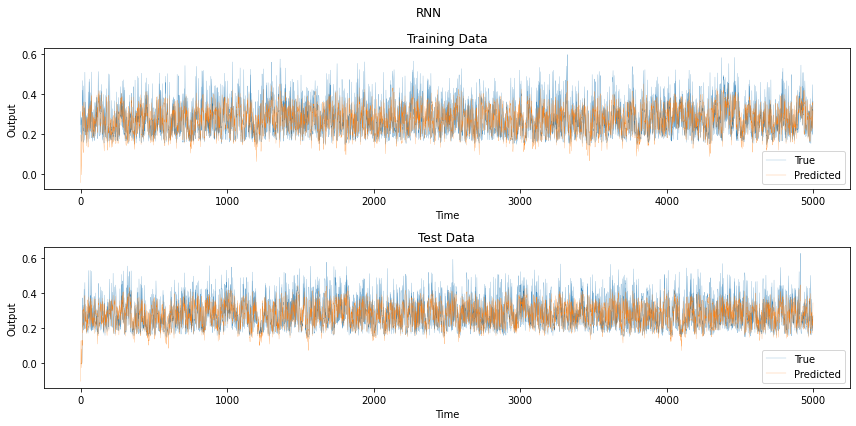

In [27]:
plot_results(whole_y_NP, whole_ypred_NP, y_t_NP, test_ypred_NP, nn)

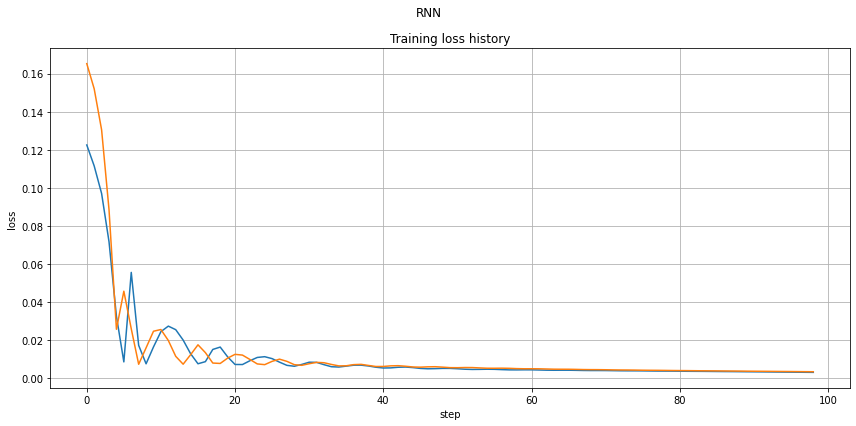

In [28]:
loss_plot(whole_loss_rnn, test_loss_rnn)